In [1]:
from sklearn.tree import plot_tree
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import numpy as np
from Levenshtein import distance as edit_distance
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import DBSCAN
import pm4py

In [2]:


# import data
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print(
        "Start activities: {}\nEnd activities: {}".format(
            start_activities,
            end_activities))
    # convert all activity codes to strings
    event_log['Activity code'] = event_log['Activity code'].astype(str)
    return event_log


event_log = import_xes("data/Hospital_log.xes.gz")
print(type(event_log))
print(event_log)

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

Start activities: {'1e consult poliklinisch': 71, 'inwend.geneesk.  korte kaart kosten-out': 8, 'verlosk.-gynaec. korte kaart kosten-out': 198, 'vervolgconsult poliklinisch': 234, 'verlosk.-gynaec.   jaarkaart kosten-out': 122, 'cytologisch onderzoek - ectocervix -': 28, 'echografie  - genitalia interna': 44, 'aanname laboratoriumonderzoek': 225, 'ligdagen - alle spec.beh.kinderg.-reval.': 39, 'telefonisch consult': 15, 'behandeltijd - eenheid t3 - megavolt': 1, 'ct abdomen': 2, 'behandeltijd - eenheid t2 - megavolt': 1, 'thorax': 12, 'e.c.g.      - elektrocardiografie': 63, 'cytologisch onderzoek - vagina -': 12, 'mammografie thoraxwand': 3, 'histologisch onderzoek - biopten nno': 19, 'dagverpleging - alle spec.beh.kind.-rev.': 5, 'inwend.geneesk.    jaarkaart kosten-out': 1, 'coupe ter inzage': 19, 'immunopathologisch onderzoek': 10, 'vagina      - scopie incl.evt.vulvabiops': 3, 'punctie tbv cytologisch onderzoek door p': 3, 'cytologisch onderzoek - buiktumorpunctie': 1, 'vrw.gesl.o

In [3]:


def label_function(log_df, required_activities):
    # Filter log to retain only traces with required activities
    filtered_df = pm4py.filtering.filter_event_attribute_values(
        log_df,
        attribute_key='concept:name',
        values=required_activities,
        level='case',
        retain=True,
        case_id_key='case:concept:name'
    )

    # Identify case IDs in the filtered DataFrame (these cases are normal)
    normal_cases = set(filtered_df['case:concept:name'].unique())

    # Create a dictionary mapping case IDs to 'normal' or 'deviant'
    case_labels = {
        case_id: 0 if case_id in normal_cases else 1
        for case_id in log_df['case:concept:name'].unique()
    }

    return case_labels


# Define required activities for this rule
required_activities_f1 = ['ca-19.9 tumormarker', 'ca-125 mbv meia']

# Generate the lf_map using the label function
lf_map = label_function(event_log, required_activities_f1)


 The part below for the running trace is in comments since it is not used
 for the actual results. But, because a running trace is part of the
 framework it is included in this part. One improvement that could be
 made here is to extract prefixes first the running trace before the
 train/test, so it is possible to choose a trace with more than 1
 element. This is not relevant to the actual framework though because a
 running trace should not come from the original training dataset.

In [4]:


# Step 1: Sort traces temporally by the first event's timestamp and split 80/20
event_log_sorted = event_log.sort_values(by='time:timestamp')
print("Sorted Event Log:\n", event_log_sorted['case:concept:name'])


# Here, we sample one trace to represent a "running" trace.
# running_trace = event_log_sorted.sample(1,random_state=17)
# event_log_sorted = event_log_sorted.drop(running_trace.index)

# Calculate the split index for 80% of the cases, without dropping duplicates
split_index = int(0.8 * len(event_log_sorted))

# Split the sorted event log directly
train_log = event_log_sorted.iloc[:split_index]
test_log = event_log_sorted.iloc[split_index:]

# Verify split sizes
print("Train log size:", len(train_log))
print("Test log size:", len(test_log))
# print("Running trace:\n", running_trace)

Sorted Event Log:
 0         00000000
374       00000004
375       00000004
377       00000004
378       00000004
            ...   
150289    00001142
75066     00000591
75065     00000591
60896     00000518
150290    00001142
Name: case:concept:name, Length: 150291, dtype: object
Train log size: 120232
Test log size: 30059


In [5]:


# Define a function to safely transform data using LabelEncoder, handling
# unknown values
def safe_transform(encoder, value):
    # Ensure "Missing" is in encoder classes
    if "Missing" not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, "Missing")

    # If the value is in the encoder's known classes, transform it; otherwise,
    # encode as "Missing"
    if value in encoder.classes_:
        return encoder.transform([value])[0]
    else:
        return encoder.transform(["Missing"])[0]

In [6]:


# Updated function with label_encoders as a parameter
def encode_data_attributes(
        event_log,
        prefixes_with_case_ids,
        attributes,
        label_encoders):
    encoded_data = []

    # Iterate over each (case_id, prefix)
    for case_id, prefix in prefixes_with_case_ids:
        # Get the last event in the current prefix
        last_event = prefix[-1]

        # Filter the event_log for the specific case and last event
        event_rows = event_log[
            (event_log['case:concept:name'] == case_id) &
            (event_log['Activity code'] == last_event)
        ]

        if event_rows.empty:
            print(
                f"No matching event found for case {case_id} and activity {last_event}")
            # Encode missing data explicitly as "Missing"
            data_vector = [
                safe_transform(
                    label_encoders[attr],
                    "Missing") for attr in attributes]
        else:
            # Take the first occurrence and encode each attribute
            event_row = event_rows.iloc[0]
            data_vector = [
                safe_transform(label_encoders[attr], str(event_row[attr]))
                for attr in attributes
            ]

        # Add the encoded vector to the results
        encoded_data.append(data_vector)

    return encoded_data

In [7]:


# Step 2: Extract prefixes from training set with specified step sizes
def extract_prefixes(trace, max_len=21, step=5):
    return [trace[:i] for i in range(1, max_len + 1, step) if i <= len(trace)]


# Group and extract prefixes from training traces
train_traces = train_log.groupby('case:concept:name')[
    'Activity code'].apply(list)
all_prefixes = train_traces.apply(lambda x: extract_prefixes(x)).explode()

In [8]:


def encode_control_flow(trace, activities):
    """
    Encode a trace based on control flow as a vector of activity frequencies.
    """
    return [trace.count(activity) for activity in activities]


# Alphabet of activities
activities = sorted(event_log['Activity code'].unique())
control_flow_encoded_prefixes = [
    encode_control_flow(prefix, activities) for prefix in all_prefixes
]

In [11]:


# Convert each encoded prefix to a sequence for DBSCAN
control_flow_encoded_sequences = [' '.join(
    map(str, encode_control_flow(prefix, activities))) for prefix in all_prefixes]

In [12]:


# Compute distance matrix based on control flow encoding
n_train = len(control_flow_encoded_prefixes)
train_distance_matrix = np.zeros((n_train, n_train))
for i in range(n_train):
    for j in range(i + 1, n_train):
        dist = edit_distance(
            control_flow_encoded_prefixes[i],
            control_flow_encoded_prefixes[j])
        train_distance_matrix[i, j] = dist
        train_distance_matrix[j, i] = dist  # Symmetric matrix

dbscan = DBSCAN(eps=0.125, min_samples=4, metric='precomputed')
train_cluster_labels = dbscan.fit_predict(train_distance_matrix)

In [13]:


# Columns used for classifier training
X_cols = ['case:Diagnosis code', 'case:Treatment code']

# Step 5: Train a classifier for each cluster in the training set
clusters = {}
encoders_per_cluster = {}  # Dictionary to store LabelEncoders for each cluster
for cluster_label in np.unique(train_cluster_labels):
    if cluster_label == -1:
        continue  # Skip noise points

    cluster_indices = [i for i, label in enumerate(
        train_cluster_labels) if label == cluster_label]
    prefixes_with_case_ids = [
        (all_prefixes.index[i], all_prefixes.iloc[i]) for i in cluster_indices
    ]

    cluster_event_log = train_log[train_log['case:concept:name'].isin(
        [case_id for case_id, _ in prefixes_with_case_ids])]
    # Initialize and fit LabelEncoders for the cluster
    label_encoders = {col: LabelEncoder() for col in X_cols}
    for col in X_cols:
        label_encoders[col].fit(cluster_event_log[col].astype(str))

    # Save the encoders for this cluster
    encoders_per_cluster[cluster_label] = label_encoders

    X_cluster = encode_data_attributes(
        train_log, prefixes_with_case_ids, X_cols, label_encoders)
    y_cluster = [lf_map[case_id] for case_id, _ in prefixes_with_case_ids]

    # Print cluster size for inspection
    print(
        f"Cluster {cluster_label}: Size of X_cluster = {len(X_cluster)}, Size of y_cluster = {len(y_cluster)}")

    # Train decision tree classifier for the current cluster
    clf = DecisionTreeClassifier()
    clf.fit(X_cluster, y_cluster)
    # Store classifier by cluster label
    clusters[cluster_label] = clf, y_cluster

Cluster 0: Size of X_cluster = 60, Size of y_cluster = 60
Cluster 1: Size of X_cluster = 195, Size of y_cluster = 195
Cluster 2: Size of X_cluster = 5, Size of y_cluster = 5
Cluster 3: Size of X_cluster = 61, Size of y_cluster = 61
Cluster 4: Size of X_cluster = 14, Size of y_cluster = 14
Cluster 5: Size of X_cluster = 164, Size of y_cluster = 164
Cluster 6: Size of X_cluster = 21, Size of y_cluster = 21
Cluster 7: Size of X_cluster = 120, Size of y_cluster = 120
Cluster 8: Size of X_cluster = 11, Size of y_cluster = 11
Cluster 9: Size of X_cluster = 15, Size of y_cluster = 15
Cluster 10: Size of X_cluster = 9, Size of y_cluster = 9
Cluster 11: Size of X_cluster = 14, Size of y_cluster = 14
Cluster 12: Size of X_cluster = 15, Size of y_cluster = 15
Cluster 13: Size of X_cluster = 12, Size of y_cluster = 12
Cluster 14: Size of X_cluster = 6, Size of y_cluster = 6
Cluster 15: Size of X_cluster = 4, Size of y_cluster = 4
Cluster 16: Size of X_cluster = 41, Size of y_cluster = 41
Cluster 1

C:\Users\georg\PycharmProjects\Predictive_Process_Mining\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


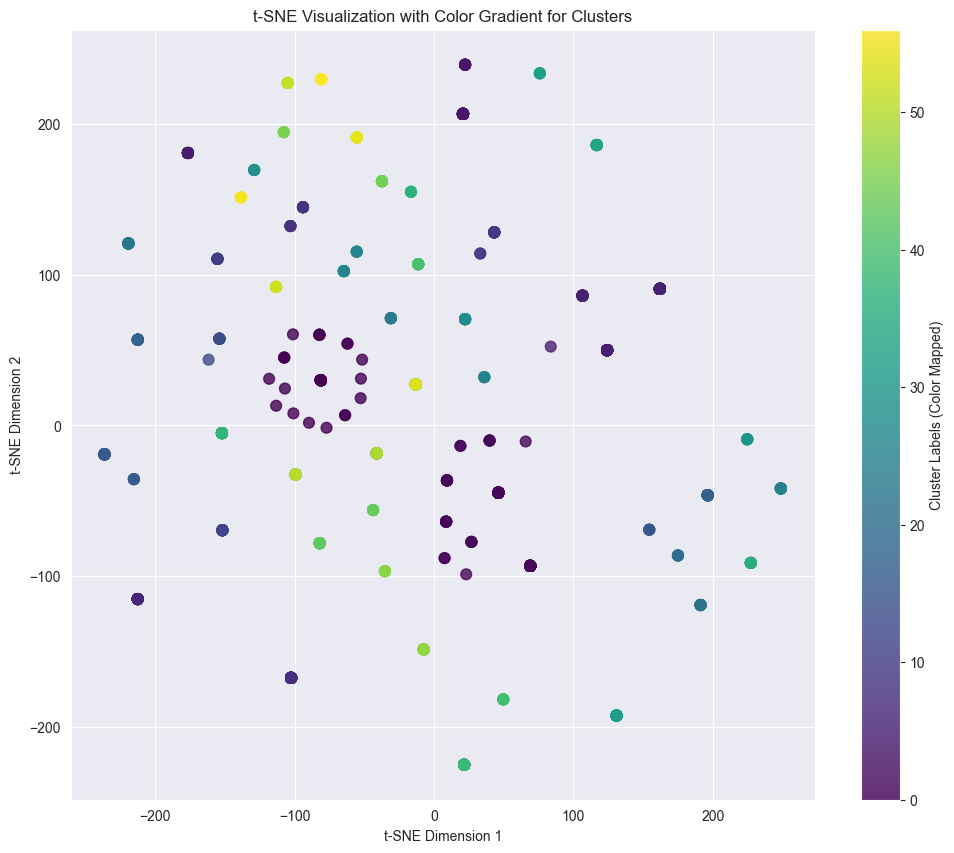

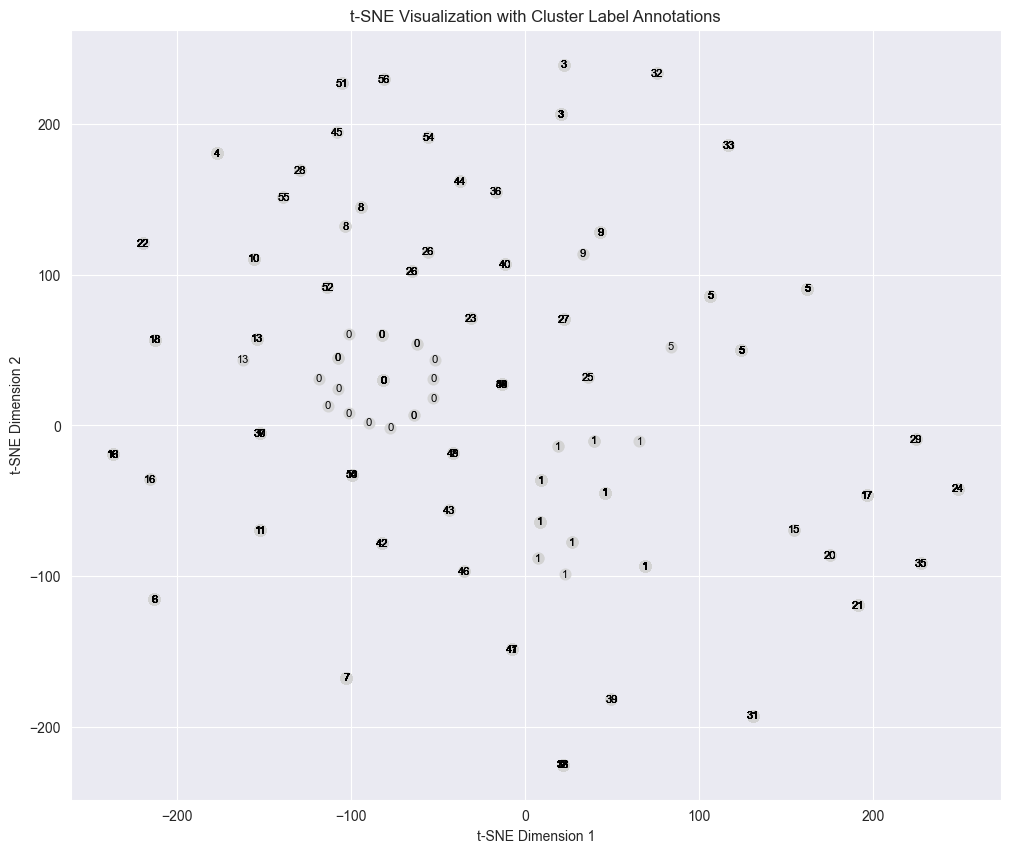

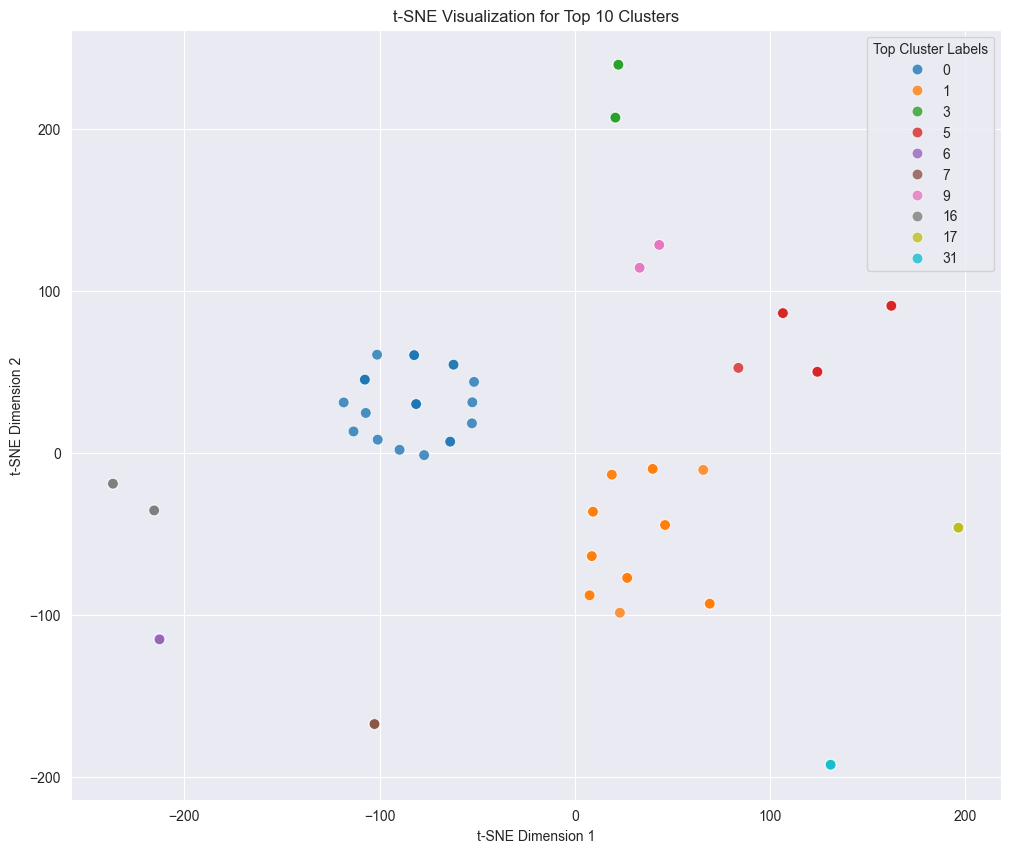

In [14]:


# Initialize placeholders for encoded clusters data and labels for
# Placeholder for data and labels to visualize clusters
visualization_data = []
visualization_labels = []

# Iterate over clusters to gather data and labels for visualization
for cluster_label, clf in clusters.items():
    # Get indices of prefixes in the current cluster
    cluster_indices = [i for i, label in enumerate(
        train_cluster_labels) if label == cluster_label]

    # Collect the encoded data for the current cluster
    X_cluster = [control_flow_encoded_prefixes[i] for i in cluster_indices]

    # Append the data and corresponding cluster labels
    visualization_data.extend(X_cluster)
    visualization_labels.extend([cluster_label] * len(X_cluster))

# Convert visualization data to a NumPy array
visualization_data = np.array(visualization_data)


# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=17, perplexity=30, n_iter=1000)
reduced_data = tsne.fit_transform(visualization_data)

# Convert reduced data into a visualization-friendly format
x_coords = reduced_data[:, 0]
y_coords = reduced_data[:, 1]

# Normalize cluster labels for color mapping
normalized_labels = np.array(visualization_labels)
unique_labels = np.unique(normalized_labels)
label_to_color = {label: i for i, label in enumerate(unique_labels)}
colors = [label_to_color[label] for label in normalized_labels]

# Create scatter plot with a color gradient
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    x_coords,
    y_coords,
    c=colors,
    cmap='viridis',  # Color map for smooth gradient
    alpha=0.8,
    s=60
)
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster Labels (Color Mapped)")
plt.title("t-SNE Visualization with Color Gradient for Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 10))
plt.scatter(
    x_coords,
    y_coords,
    c="lightgrey",  # Neutral background for the points
    alpha=0.8,
    s=60
)

# Annotate each point with its cluster label
for i, label in enumerate(visualization_labels):
    plt.text(
        x_coords[i],
        y_coords[i],
        str(label),
        fontsize=8,
        ha="center",
        va="center",
        color="black"
    )

plt.title("t-SNE Visualization with Cluster Label Annotations")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


# Count cluster frequencies
cluster_counts = Counter(visualization_labels)
top_clusters = [
    label for label,
    _ in cluster_counts.most_common(10)]  # Top 10 clusters

# Filter data for top clusters
filtered_x = [x for i, x in enumerate(
    x_coords) if visualization_labels[i] in top_clusters]
filtered_y = [y for i, y in enumerate(
    y_coords) if visualization_labels[i] in top_clusters]
filtered_labels = [
    label for label in visualization_labels if label in top_clusters]

plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=filtered_x,
    y=filtered_y,
    hue=filtered_labels,
    palette="tab10",
    legend="full",
    s=60,
    alpha=0.8
)
plt.title("t-SNE Visualization for Top 10 Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Top Cluster Labels")
plt.grid(True)
plt.show()

In [15]:


def predict_with_reliability(
        clf,
        x_test,
        threshold,
        min_class_support,
        y_cluster):
    """
    Predict with reliability by checking class probability and class support.

    Args:
        clf: Trained classifier for a specific cluster.
        x_test: Encoded test data for prediction.
        threshold: Minimum class probability threshold for reliability.
        min_class_support: Minimum number of samples supporting the predicted class.
        y_cluster: True labels of training data points used in this cluster.

    Returns:
        predicted_class: The predicted class if the prediction is reliable, otherwise None.
        class_prob: The probability of the predicted class if reliable, otherwise None.
    """
    # Get prediction probabilities for the test input
    probs = clf.predict_proba([x_test])[0]
    # Index of the class with the highest probability
    predicted_class_idx = np.argmax(probs)
    # Map index back to the class label
    predicted_class = clf.classes_[predicted_class_idx]
    # Probability of the predicted class
    class_prob = probs[predicted_class_idx]

    # Calculate class support: count how many training labels in the cluster
    # match the predicted class
    class_support = np.sum(np.array(y_cluster) == predicted_class)

    # Check reliability based on minimum class support and probability
    # threshold
    if class_support >= min_class_support and class_prob >= threshold:
        return predicted_class, class_prob

    return None, None

In [16]:


# Inspect keys in lf_map
# Display the first few keys for inspection
print("Keys in lf_map:", list(lf_map.items()))

Keys in lf_map: [('00000000', 1), ('00000001', 1), ('00000002', 0), ('00000003', 1), ('00000004', 0), ('00000005', 1), ('00000006', 0), ('00000007', 0), ('00000008', 1), ('00000009', 0), ('00000010', 0), ('00000011', 0), ('00000012', 0), ('00000013', 1), ('00000014', 1), ('00000015', 1), ('00000016', 1), ('00000017', 0), ('00000018', 0), ('00000019', 1), ('00000020', 0), ('00000021', 1), ('00000022', 1), ('00000023', 0), ('00000024', 1), ('00000025', 1), ('00000026', 1), ('00000027', 0), ('00000028', 1), ('00000029', 1), ('00000030', 0), ('00000031', 1), ('00000032', 0), ('00000033', 0), ('00000034', 1), ('00000035', 1), ('00000036', 0), ('00000037', 1), ('00000038', 0), ('00000039', 0), ('00000040', 1), ('00000041', 1), ('00000042', 1), ('00000043', 1), ('00000044', 0), ('00000045', 0), ('00000046', 1), ('00000047', 0), ('00000048', 0), ('00000049', 1), ('00000050', 1), ('00000051', 1), ('00000052', 0), ('00000053', 1), ('00000054', 0), ('00000055', 1), ('00000056', 1), ('00000057', 1

In [9]:
num_cases = test_log['case:concept:name'].nunique()
print(f"Number of unique cases in the testing set: {num_cases}")

num_activity_sequences = len(test_log.groupby('case:concept:name')['Activity code'])
print(f"Number of activity sequences in the testing set: {num_activity_sequences}")

activity_lengths = test_log.groupby('case:concept:name')['Activity code'].apply(len)
print("Lengths of activity sequences for each case:")
print(activity_lengths)

Number of unique cases in the testing set: 548
Number of activity sequences in the testing set: 548
Lengths of activity sequences for each case:
case:concept:name
00000003      1
00000005      5
00000008      3
00000012    541
00000014      1
           ... 
00001138     31
00001139     26
00001140     27
00001141     30
00001142     26
Name: Activity code, Length: 548, dtype: int64


In [17]:


# Store true and predicted labels
true_labels = []
predicted_labels = []
# Store reliable and failed predictions sum
reliable_prediction_counter = 0
failed_prediction_counter = 0
# Define the sequence of steps
step_sequence = [21, 16, 11, 6, 1]
max_prefix_length = 21  # Set the maximum prefix length
# Define experiment parameters
threshold = [0.6]
min_class_support = 6

# Iterate over each test trace with case IDs
for case_id, test_trace in test_log.groupby('case:concept:name')[
        'Activity code'].apply(list).items():
    reliable_prediction = False
    y_test = lf_map.get(case_id)  # Get true label for the test trace
    y_pred = None  # Initialize predicted label for the trace

    if y_test is None:
        print(f"Warning: No label found for {case_id} in lf_map")
        continue

    current_step = max_prefix_length
    while current_step > 0 and len(
            test_trace[:current_step]) <= max_prefix_length:
        current_prefix = test_trace[:current_step]

        # Step 1: Encode the current prefix using control flow
        encoded_prefix = encode_control_flow(current_prefix, activities)

        # Step 2: Find the closest cluster by computing edit distances
        distances = [
            edit_distance(encoded_prefix, train_prefix)
            for train_prefix in control_flow_encoded_prefixes
        ]
        closest_idx = np.argmin(distances)
        closest_cluster = train_cluster_labels[closest_idx]

        if closest_cluster == -1:
            # Move to the next prefix step if the closest cluster is noise
            current_step -= step_sequence.pop(0) if step_sequence else 5
            continue

        # Step 3: Retrieve the classifier and LabelEncoders for the closest
        # cluster
        clf, y_cluster = clusters.get(closest_cluster)
        label_encoders = encoders_per_cluster.get(closest_cluster)

        if clf and y_cluster and label_encoders:
            # Step 4: Encode the data attributes of the current prefix's last
            # event
            prefixes_with_case_ids = [(case_id, current_prefix)]
            X_test = encode_data_attributes(
                test_log, prefixes_with_case_ids, X_cols, label_encoders
            )[0]

            # Step 5: Make a prediction with reliability checking
            y_pred, confidence = predict_with_reliability(
                clf, X_test, threshold, min_class_support, y_cluster)

            if y_pred is not None:
                print(
                    f"Reliable prediction achieved: {y_pred} with confidence {confidence}")
                reliable_prediction_counter += 1
                reliable_prediction = True
                break  # Stop if a reliable prediction is made

        # Move to the next step in the sequence
        current_step -= step_sequence.pop(0) if step_sequence else 5

    # Append the final true and predicted labels for evaluation
    true_labels.append(y_test)
    predicted_labels.append(y_pred if reliable_prediction else None)

    if not reliable_prediction:
        failed_prediction_counter += 1
        print(
            f"Prediction failure: No reliable prediction achieved for case {case_id}.")


# Final evaluation
print(f"Total reliable predictions: {reliable_prediction_counter}")
print(f"Total failed predictions: {failed_prediction_counter}")

Reliable prediction achieved: 1 with confidence 1.0
Prediction failure: No reliable prediction achieved for case 00000005.
Reliable prediction achieved: 1 with confidence 0.8585858585858586
Reliable prediction achieved: 1 with confidence 0.8585858585858586
Reliable prediction achieved: 1 with confidence 0.8585858585858586
Reliable prediction achieved: 1 with confidence 0.8585858585858586
Reliable prediction achieved: 1 with confidence 0.76
Reliable prediction achieved: 1 with confidence 0.76
Reliable prediction achieved: 1 with confidence 0.76
Reliable prediction achieved: 1 with confidence 0.8585858585858586
Reliable prediction achieved: 0 with confidence 1.0
Reliable prediction achieved: 1 with confidence 0.76
Reliable prediction achieved: 1 with confidence 0.76
Reliable prediction achieved: 1 with confidence 0.76
Reliable prediction achieved: 1 with confidence 0.76
Reliable prediction achieved: 1 with confidence 0.8585858585858586
Reliable prediction achieved: 1 with confidence 0.76

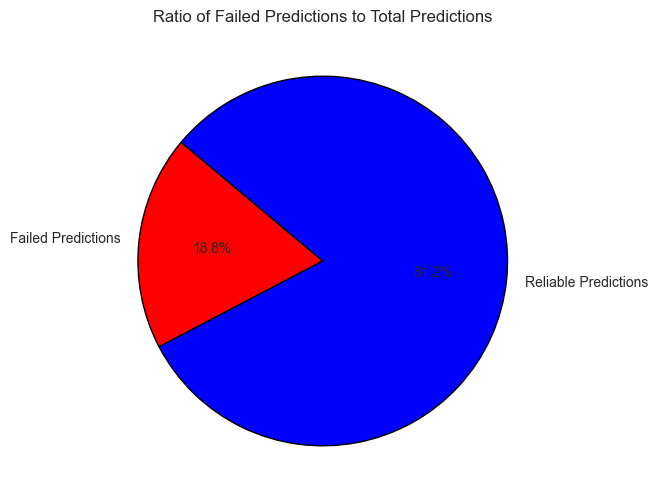

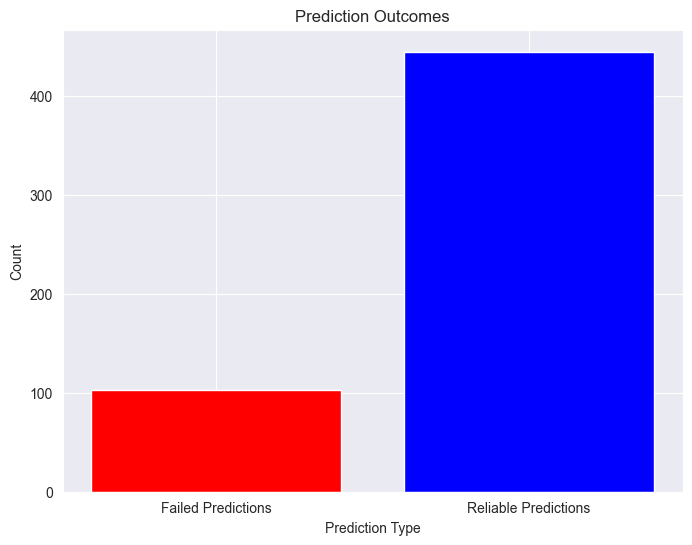

In [18]:


# Calculate total predictions
total_predictions = failed_prediction_counter + reliable_prediction_counter

# Data for visualization
labels = ['Failed Predictions', 'Reliable Predictions']
sizes = [failed_prediction_counter, reliable_prediction_counter]
colors = ['red', 'blue']

# Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={
        'edgecolor': 'black'})
plt.title("Ratio of Failed Predictions to Total Predictions")
plt.show()

# Alternatively, a bar chart if preferred
plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=colors)
plt.xlabel('Prediction Type')
plt.ylabel('Count')
plt.title("Prediction Outcomes")
plt.show()

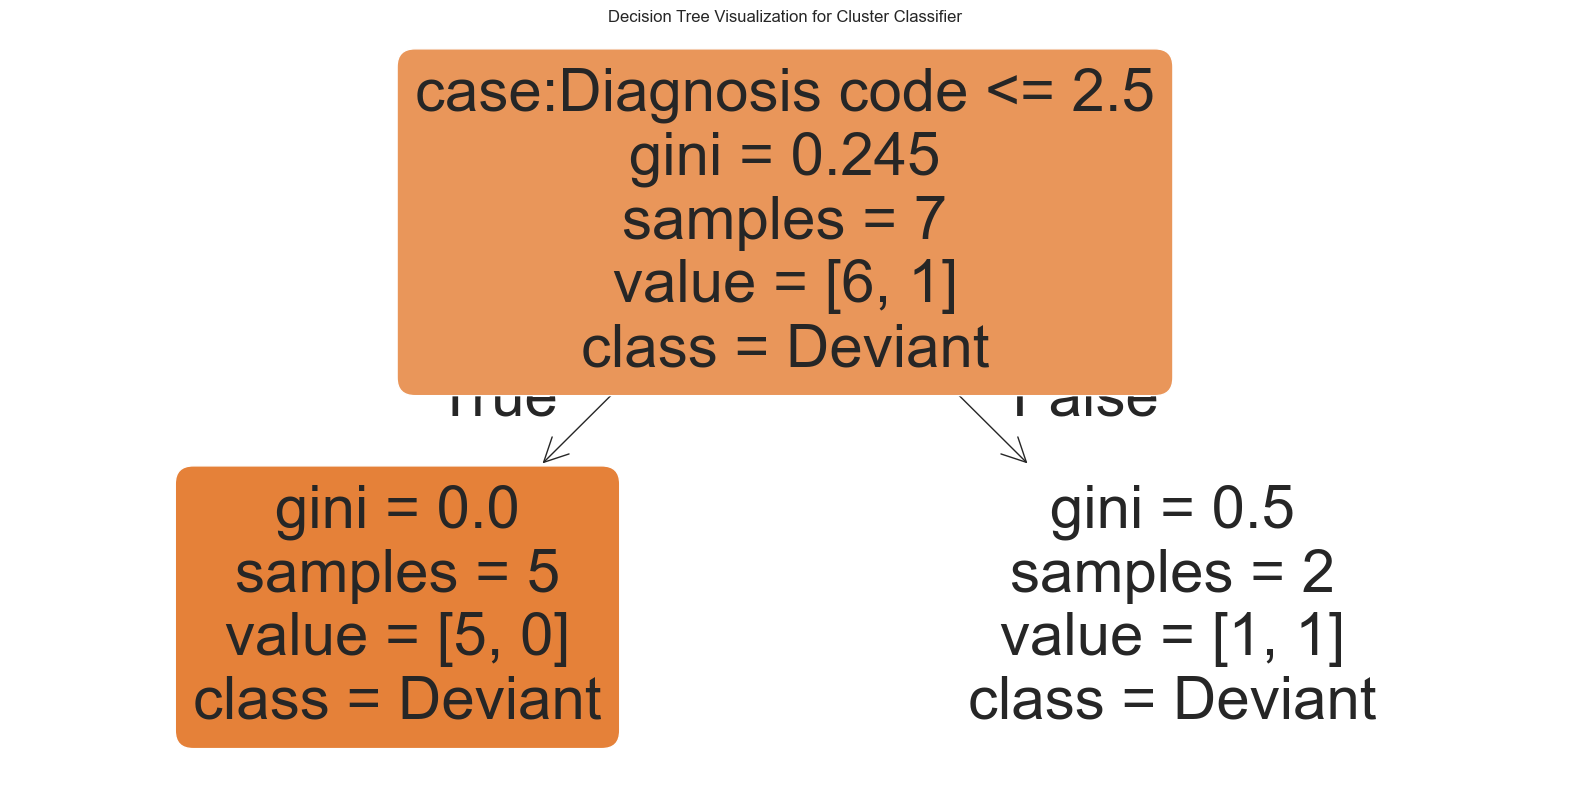

In [19]:


def visualize_decision_tree(clf, feature_names):
    plt.figure(figsize=(20, 10))
    plot_tree(
        clf,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        class_names=[
            "Deviant",
            "Normal"])
    plt.title("Decision Tree Visualization for Cluster Classifier")
    plt.show()


if clf is not None:
    # Feature names would be the attributes used in the decision tree, for
    # example:
    feature_names = X_cols  # ['case:Diagnosis code', 'case:Treatment code']
    visualize_decision_tree(clf, feature_names)

F1 Score: 0.768


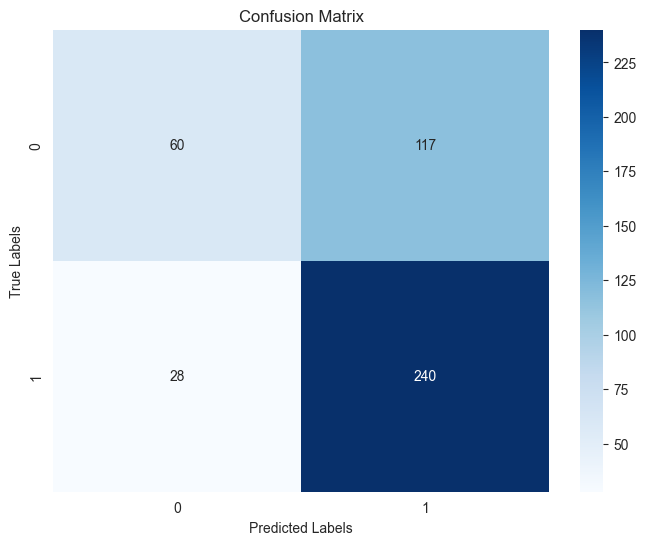

In [20]:


# Filter out cases where no reliable prediction was made (i.e., where
# y_pred is None)
filtered_true_labels = [
    y for y,
    pred in zip(
        true_labels,
        predicted_labels) if pred is not None]
filtered_predicted_labels = [
    pred for pred in predicted_labels if pred is not None]

# Check if there are any valid predictions left for evaluation
if filtered_predicted_labels:
    # Evaluate the predictions
    f1 = f1_score(
        filtered_true_labels,
        filtered_predicted_labels,
        average='binary')
    print(f'F1 Score: {f1:.3f}')

    # Plot the confusion matrix
    cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', xticklabels=[
            0, 1], yticklabels=[
            0, 1])  # Updated labels to match integer encoding
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("No valid predictions to evaluate. Check clustering, classifier training, or reliability criteria.")


## The code below could be used to predict a running trace. This is not required to test F1 score for our final results but it is part of the framework so it is meaningful to add it as part of our code even in comments.

In [21]:


'''


# Step 1: Preprocess and encode the running trace using the same method as train/test data
running_trace_case_id = running_trace['case:concept:name'].iloc[0]
running_trace_activities = running_trace[
    running_trace['case:concept:name'] == running_trace_case_id]['Activity code'].tolist()

# Step 2: Iterate over prefixes of the running trace and make predictions
for i in range(1, len(running_trace_activities) + 1):
    current_prefix = running_trace_activities[:i]
    print(f"\n--- Prefix Length {i} ---")
    print("Current Prefix:", current_prefix)

    # Step 3: Encode the current prefix using control flow
    control_flow_encoded_prefix = encode_control_flow(current_prefix, activities)

    # Step 4: Find the closest cluster by computing edit distances with training encoded prefixes
    distances = [
        edit_distance(control_flow_encoded_prefix, train_prefix)
        for train_prefix in control_flow_encoded_prefixes
    ]
    closest_idx = np.argmin(distances)
    closest_cluster = train_cluster_labels[closest_idx]

    if closest_cluster == -1:
        print("Closest cluster is noise, skipping this prefix.")
        continue

    # Step 5: Retrieve the classifier and LabelEncoders for the closest cluster
    cluster_data = clusters.get(closest_cluster)
    label_encoders = encoders_per_cluster.get(closest_cluster)

    if not cluster_data or not label_encoders:
        print("No classifier or label encoders available for the closest cluster. Skipping.")
        continue

    clf, y_cluster = cluster_data

    # Step 6: Encode the data attributes of the last event in the current prefix
    prefixes_with_case_ids = [(running_trace_case_id, current_prefix)]
    X_test = encode_data_attributes(
        running_trace, prefixes_with_case_ids, X_cols, label_encoders
    )[0]

    # Step 7: Predict the label using the classifier of the closest cluster
    y_pred, confidence = predict_with_reliability(clf, X_test, threshold, min_class_support, y_cluster)

    if y_pred is not None:
        print(f"Predicted label for prefix {i}: {y_pred} with confidence: {confidence}")
    else:
        print(f"Prediction for prefix {i} deemed unreliable.")

'''


'\n\n\n# Step 1: Preprocess and encode the running trace using the same method as train/test data\nrunning_trace_case_id = running_trace[\'case:concept:name\'].iloc[0]\nrunning_trace_activities = running_trace[\n    running_trace[\'case:concept:name\'] == running_trace_case_id][\'Activity code\'].tolist()\n\n# Step 2: Iterate over prefixes of the running trace and make predictions\nfor i in range(1, len(running_trace_activities) + 1):\n    current_prefix = running_trace_activities[:i]\n    print(f"\n--- Prefix Length {i} ---")\n    print("Current Prefix:", current_prefix)\n\n    # Step 3: Encode the current prefix using control flow\n    control_flow_encoded_prefix = encode_control_flow(current_prefix, activities)\n\n    # Step 4: Find the closest cluster by computing edit distances with training encoded prefixes\n    distances = [\n        edit_distance(control_flow_encoded_prefix, train_prefix)\n        for train_prefix in control_flow_encoded_prefixes\n    ]\n    closest_idx = np.ar

We can visualise all trees per cluster as well but it is not needed.

In [22]:


'''
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Function to visualize a decision tree for a specific cluster
def visualize_decision_tree(clf, feature_names, cluster_label):
    """
    Visualize a trained decision tree classifier.

    Parameters:
    - clf: Trained DecisionTreeClassifier object.
    - feature_names: List of feature names used in the decision tree.
    - cluster_label: Label of the cluster corresponding to this classifier.
    """
    plt.figure(figsize=(20, 10))
    plot_tree(
        clf,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        class_names=["Deviant", "Normal"]
    )
    plt.title(f"Decision Tree Visualization for Cluster {cluster_label}")
    plt.show()

# Visualize the decision trees for all trained cluster classifiers
for cluster_label, (clf, _) in clusters.items():
    print(f"Visualizing Decision Tree for Cluster {cluster_label}...")
    visualize_decision_tree(clf, feature_names=X_cols, cluster_label=cluster_label)

'''

'\nfrom sklearn.tree import plot_tree\nimport matplotlib.pyplot as plt\n\n# Function to visualize a decision tree for a specific cluster\ndef visualize_decision_tree(clf, feature_names, cluster_label):\n    """\n    Visualize a trained decision tree classifier.\n\n    Parameters:\n    - clf: Trained DecisionTreeClassifier object.\n    - feature_names: List of feature names used in the decision tree.\n    - cluster_label: Label of the cluster corresponding to this classifier.\n    """\n    plt.figure(figsize=(20, 10))\n    plot_tree(\n        clf,\n        feature_names=feature_names,\n        filled=True,\n        rounded=True,\n        class_names=["Deviant", "Normal"]\n    )\n    plt.title(f"Decision Tree Visualization for Cluster {cluster_label}")\n    plt.show()\n\n# Visualize the decision trees for all trained cluster classifiers\nfor cluster_label, (clf, _) in clusters.items():\n    print(f"Visualizing Decision Tree for Cluster {cluster_label}...")\n    visualize_decision_tree(cl